## Vecotr Space Model for the State of Union Addresses

In [38]:
from pyspark.sql import SparkSession

spark  = SparkSession.builder.master('local').appName('SOU').getOrCreate()
df = spark.read.json('/project/cmsc25025/sou/speeches.json')
print type(df)
df.show()

<class 'pyspark.sql.dataframe.DataFrame'>
+--------------------+--------------------+----+
|           president|                text|year|
+--------------------+--------------------+----+
|        James Monroe| Fellow-Citizens ...|1821|
|    William McKinley| To the Senate an...|1897|
|Dwight D. Eisenhower|[Delivered in per...|1960|
|     Calvin Coolidge|Since the close o...|1923|
|       James Madison| Fellow-Citizens ...|1816|
|    Grover Cleveland| To the Congress ...|1886|
|   John Quincy Adams| Fellow Citizens ...|1827|
|  Theodore Roosevelt| To the Senate an...|1905|
|   Lyndon B. Johnson|Mr. Speaker, Mr. ...|1965|
|       James K. Polk| Fellow-Citizens ...|1848|
|      Woodrow Wilson|Gentlemen of the ...|1913|
|Dwight D. Eisenhower|[Delivered in per...|1955|
|         George Bush|Mr. President and...|1991|
|     Franklin Pierce| Fellow-Citizens ...|1856|
...|1944|
|   Lyndon B. Johnson|[Delivered in per...|1968|
|      Andrew Johnson| Fellow-Citizens ...|1867|
|      Woodrow Wi

# (a) Compute TF-IDF vectors
## 1. build vocabulary
(throw out the 20 most common words and words that appear fewer than 50 times)

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import string
from collections import Counter
import math
from pprint import pprint
import re

%matplotlib inline
def clean(x):
    # clean text: remove punctuation and split
    # encode to UTF-8, convert to lowercase and translate all hyphens and punctuation to whitespace
    s = x.lower().encode('utf-8').translate(string.maketrans("",""), string.punctuation)
    # replace \r\n
    s = re.sub('(\r\n)+',' ',s)
    # replace whitespace substrings with one whitespace and remove leading/trailing whitespaces
    s = re.sub(' +',' ',s.strip())
    return s.split(' ')

clean_df = df.rdd.map(lambda x: (x['year'], x['president'], clean(x['text']))).cache()
# count frequency of each word
word_counts = clean_df.flatMap(lambda x: x[2]).map(lambda x: (x, 1)).reduceByKey(lambda a, b: a+b)
# remove the 20 most frequent words
vocab1 = word_counts.sortBy(lambda x: x[1], ascending=False).zipWithIndex().filter(lambda x: x[1]>=20).keys().keys()
# remove words appear in less than 50 documents
idf = clean_df.flatMap(lambda x: list(set(x[2]))).map(lambda x: (x, 1)).reduceByKey(lambda a, b:a+b).filter(lambda x: x[1] > 50)
# Use intersection and get the final vocabulary
vocab = vocab1.intersection(idf.keys())


## 2. compute TF-IDF vectors

In [40]:
from __future__ import division
D = clean_df.count()
data = clean_df.collect()
def get_tf_idf_vec(words):
    #calculate the tf_idf vector
    #tf is the word counts in certain documents
    tf = vocab.map(lambda w: (w, words.count(w)))
    #idf records the word counts across all the docuemtns
    vec = tf.join(idf).map(lambda x: x[1][0] * np.log(D / x[1][1])).collect()
    return vec



In [42]:
tf_idf = spark.sparkContext.parallelize([(x[0], x[1], get_tf_idf_vec(x[2])) for x in data])

# (b) Similarity measure

In [56]:
def normalize(vec):
    length = np.linalg.norm(vec)
    return vec / length
def cal_sim(vec1, vec2):
    return vec1.dot(vec2)
tf_idf = tf_idf.map(lambda x: (x[0], x[1], normalize(x[2])))
pairs = tf_idf.cartesian(tf_idf).filter(lambda x: x[0][0] < x[1][0])
pairs = pairs.map(lambda x: (x[0][0], x[1][0], x[0][1], x[1][1], float(cal_sim(x[0][2], x[1][2]))))

In [57]:
sims = spark.createDataFrame(pairs, ["year1","year2","president1","president2","sim"])
sims.show(n=10)

+-----+-----+------------+--------------------+-------------------+
|year1|year2|  president1|          president2|                sim|
+-----+-----+------------+--------------------+-------------------+
| 1821| 1897|James Monroe|    William McKinley|0.31223824730188926|
| 1821| 1960|James Monroe|Dwight D. Eisenhower|0.11475700502896191|
| 1821| 1923|James Monroe|     Calvin Coolidge|0.22205693301902685|
| 1821| 1886|James Monroe|    Grover Cleveland|0.34439513649206693|
| 1821| 1827|James Monroe|   John Quincy Adams| 0.3967445272883114|
| 1821| 1905|James Monroe|  Theodore Roosevelt|0.25781925739873673|
| 1821| 1965|James Monroe|   Lyndon B. Johnson|0.05965864430803461|
| 1821| 1848|James Monroe|       James K. Polk|0.36518555977298905|
| 1821| 1913|James Monroe|      Woodrow Wilson| 0.1453555579416126|
| 1821| 1955|James Monroe|Dwight D. Eisenhower| 0.1021509343517665|
+-----+-----+------------+--------------------+-------------------+
only showing top 10 rows



In [52]:
# 10 most similar speeches from different presidents
sims.filter("president1 != president2").sort("sim", ascending=False).show(n=10)

+-----+-----+--------------------+-------------------+------------------+
|year1|year2|          president1|         president2|               sim|
+-----+-----+--------------------+-------------------+------------------+
| 1961| 1981|Dwight D. Eisenhower|       Jimmy Carter|0.6857245408422247|
| 1889| 1885|   Benjamin Harrison|   Grover Cleveland|0.6752323398820435|
| 2010| 1994|        Barack Obama| William J. Clinton| 0.665564842370267|
| 1956| 1981|Dwight D. Eisenhower|       Jimmy Carter|0.6609498458826516|
| 1955| 1981|Dwight D. Eisenhower|       Jimmy Carter|0.6570077627127071|
| 1885| 1877|    Grover Cleveland|Rutherford B. Hayes|0.6542466836961661|
| 1836| 1839|      Andrew Jackson|   Martin Van Buren|0.6490040144255912|
| 2004| 1998|      George W. Bush| William J. Clinton|0.6472638061326981|
| 1992| 1995|         George Bush| William J. Clinton|0.6443849085874218|
| 2010| 1995|        Barack Obama| William J. Clinton|0.6438262453966554|
+-----+-----+--------------------+----

In [58]:
# 10 most similar speeches from same presidents
sims.filter("president1 == president2").sort("sim", ascending=False).show(n=10)

+-----+-----+-------------------+-------------------+------------------+
|year1|year2|         president1|         president2|               sim|
+-----+-----+-------------------+-------------------+------------------+
| 2012| 2013|       Barack Obama|       Barack Obama|0.9854545803054573|
| 1846| 1847|      James K. Polk|      James K. Polk|0.8059963426709121|
| 1899| 1900|   William McKinley|   William McKinley|0.7538458493976826|
| 1998| 1999| William J. Clinton| William J. Clinton|0.7504868525514592|
| 1998| 2000| William J. Clinton| William J. Clinton|0.7498147630134475|
| 1997| 1998| William J. Clinton| William J. Clinton| 0.748770439121618|
| 2010| 2012|       Barack Obama|       Barack Obama|0.7398699727437701|
| 2011| 2012|       Barack Obama|       Barack Obama|0.7397177538615023|
| 1910| 1912|William Howard Taft|William Howard Taft|0.7383482337778927|
| 1994| 1995| William J. Clinton| William J. Clinton|0.7365469687090234|
+-----+-----+-------------------+------------------

In [64]:
#10 most similar presidents
sims.filter("president1 != president2").groupBy(['president1', 'president2']).agg({'sim': 'mean'}).orderBy('avg(sim)', ascending = False).show(n=10)

+-------------------+-------------------+------------------+
|         president1|         president2|          avg(sim)|
+-------------------+-------------------+------------------+
| William J. Clinton|       Barack Obama|0.5571058679188831|
|     Zachary Taylor|   Millard Fillmore|0.5526382143920262|
|Rutherford B. Hayes|  Benjamin Harrison|0.5491956198412178|
|Rutherford B. Hayes|  Chester A. Arthur|0.5441774097979725|
|  Chester A. Arthur|  Benjamin Harrison|0.5413166449996004|
| Theodore Roosevelt|William Howard Taft|0.5253551046466506|
|  Benjamin Harrison|   Grover Cleveland|0.5227429995773583|
|     Zachary Taylor|     James Buchanan|0.5188822243064843|
|      James K. Polk|     Zachary Taylor|0.5179350678439684|
|        George Bush| William J. Clinton|0.5147944112144421|
+-------------------+-------------------+------------------+
only showing top 10 rows



# (c) K-means clustering
## k = 3 and K = 5

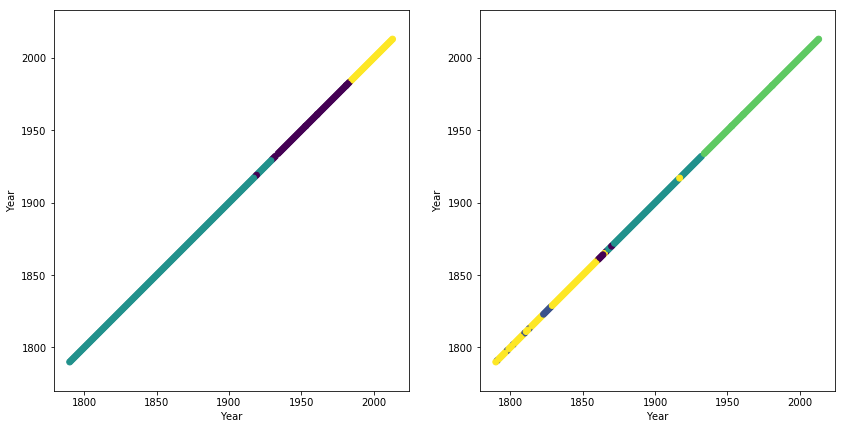

In [72]:
def plot_cluster(years, label):
    plt.scatter(years, years, c = label)
    plt.xlabel('Year')
    plt.ylabel('Year')
    plt.axis('equal')
    
from pyspark.mllib.clustering import KMeans
from pprint import pprint
tf_idf_vec = tf_idf.map(lambda x: x[2])
years = tf_idf.map(lambda x: x[0]).collect()
# Test with two different clustering numbers
n_clusters = [3, 5]
n_col = 2
n_row = 1
plt.figure(figsize = (n_col * 7, n_row * 7))
for i in range(len(n_clusters)):
    clusters = KMeans.train(tf_idf_vec, n_clusters[i], maxIterations=50, initializationMode="random")
    label = clusters.predict(tf_idf_vec).collect()
    plt.subplot(n_row, n_col, i+1)
    plot_cluster(years, label)
plt.show()

In [73]:
spark.stop()